In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    time_ind = 13*24
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesW) as dsW:
        deptht = dsT.variables['deptht'][:]
        sozotaux = dsU.variables['sozotaux'][:time_ind,0,0]        
        vovecrtz0 = dsW.variables['vovecrtz'][:time_ind,depth_ind,y,x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0,depth_ind,y,x]
        
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))  
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vovecrtz, tmask, sozotaux, deptht

In [3]:
def get_w_at_point(dirname):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = 65, 130
    time_ind = 13*24
    
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    
    with scDataset(filesW) as dsW:      
        vovecrtz0 = dsW.variables['vovecrtz'][:time_ind, : , y, x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :, y, x]
        
    tmask_point = np.tile(tmask0, (vovecrtz0.shape[0], 1))  
    vovecrtz_point = np.ma.array(vovecrtz0, mask=1 - tmask_point)
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    cm_times = np.linspace(0, 1, vovecrtz_point.shape[-1])
    colors = [cm.Spectral_r(x) for x in cm_times]
    ts = np.arange(vovecrtz_point.shape[-2])
    for z in range(vovecrtz_point.shape[-1]):
        ax.plot(ts, vovecrtz_point[:, z], c=colors[z], label=str(z))
    
    return vovecrtz_point, tmask_point, fig

In [4]:
def get_1day_avg(sal, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    sal_day = np.mean(sal[day, ...], axis=0)
    return sal_day

In [5]:
def get_daily_w(vovecrtz, tmask):
    
    vovecrtz_daily0 = np.full((vovecrtz.shape[-3]/24, vovecrtz.shape[-2], vovecrtz.shape[-1]), np.nan)
    for i in range(vovecrtz_daily0.shape[0]):
        day_start, day_end = i, i+1
        vovecrtz_daily0[i, :, :] = get_1day_avg(vovecrtz, day_start, day_end)

    tmask_new = np.tile(tmask[0, :, :], (vovecrtz_daily0.shape[0], 1, 1))
    vovecrtz_daily = np.ma.array(vovecrtz_daily0, mask=1 - tmask_new)

    print(type(vovecrtz_daily0), vovecrtz_daily0.shape, tmask_new.shape, vovecrtz_daily.shape, type(vovecrtz_daily))
    
    return vovecrtz_daily, tmask_new

In [6]:
def pcolor_story_panels(plot_array, cmap, norm, vmin, vmax, title, cblabel):
    
    fig, axes = plt.subplots(3, 4, figsize = (20, 20))
    for ax, n in zip(axes.flatten(), np.arange(12)):  
        p = ax.pcolormesh(plot_array[n, :, :], cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([0, plot_array.shape[-1]])
        ax.set_ylim([0, plot_array.shape[-2]])
        ax.set_title('Day ' + str(n+1), fontsize=20)
        ax.axvline(130, c='k')
        #ax.axhline(60, c='k')
        if n == 0:
            cbar = fig.colorbar(p, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
            cbar.set_label(cblabel, fontsize=18, rotation=0, labelpad=2.5)
            cbar.ax.tick_params(labelsize=13)
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
        else:
            pass
    fig.tight_layout(w_pad=1.2, h_pad=0.01)
    fig.suptitle(title + ' [Depth = '+str(int(deptht[dep_ind]))+' m]', fontsize=25)
    plt.subplots_adjust(top=0.95)

    return fig

In [7]:
cmap, norm = cmo.cm.balance, None
cmap.set_bad('wheat')

# Ideal_half

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


0.002884147378305594

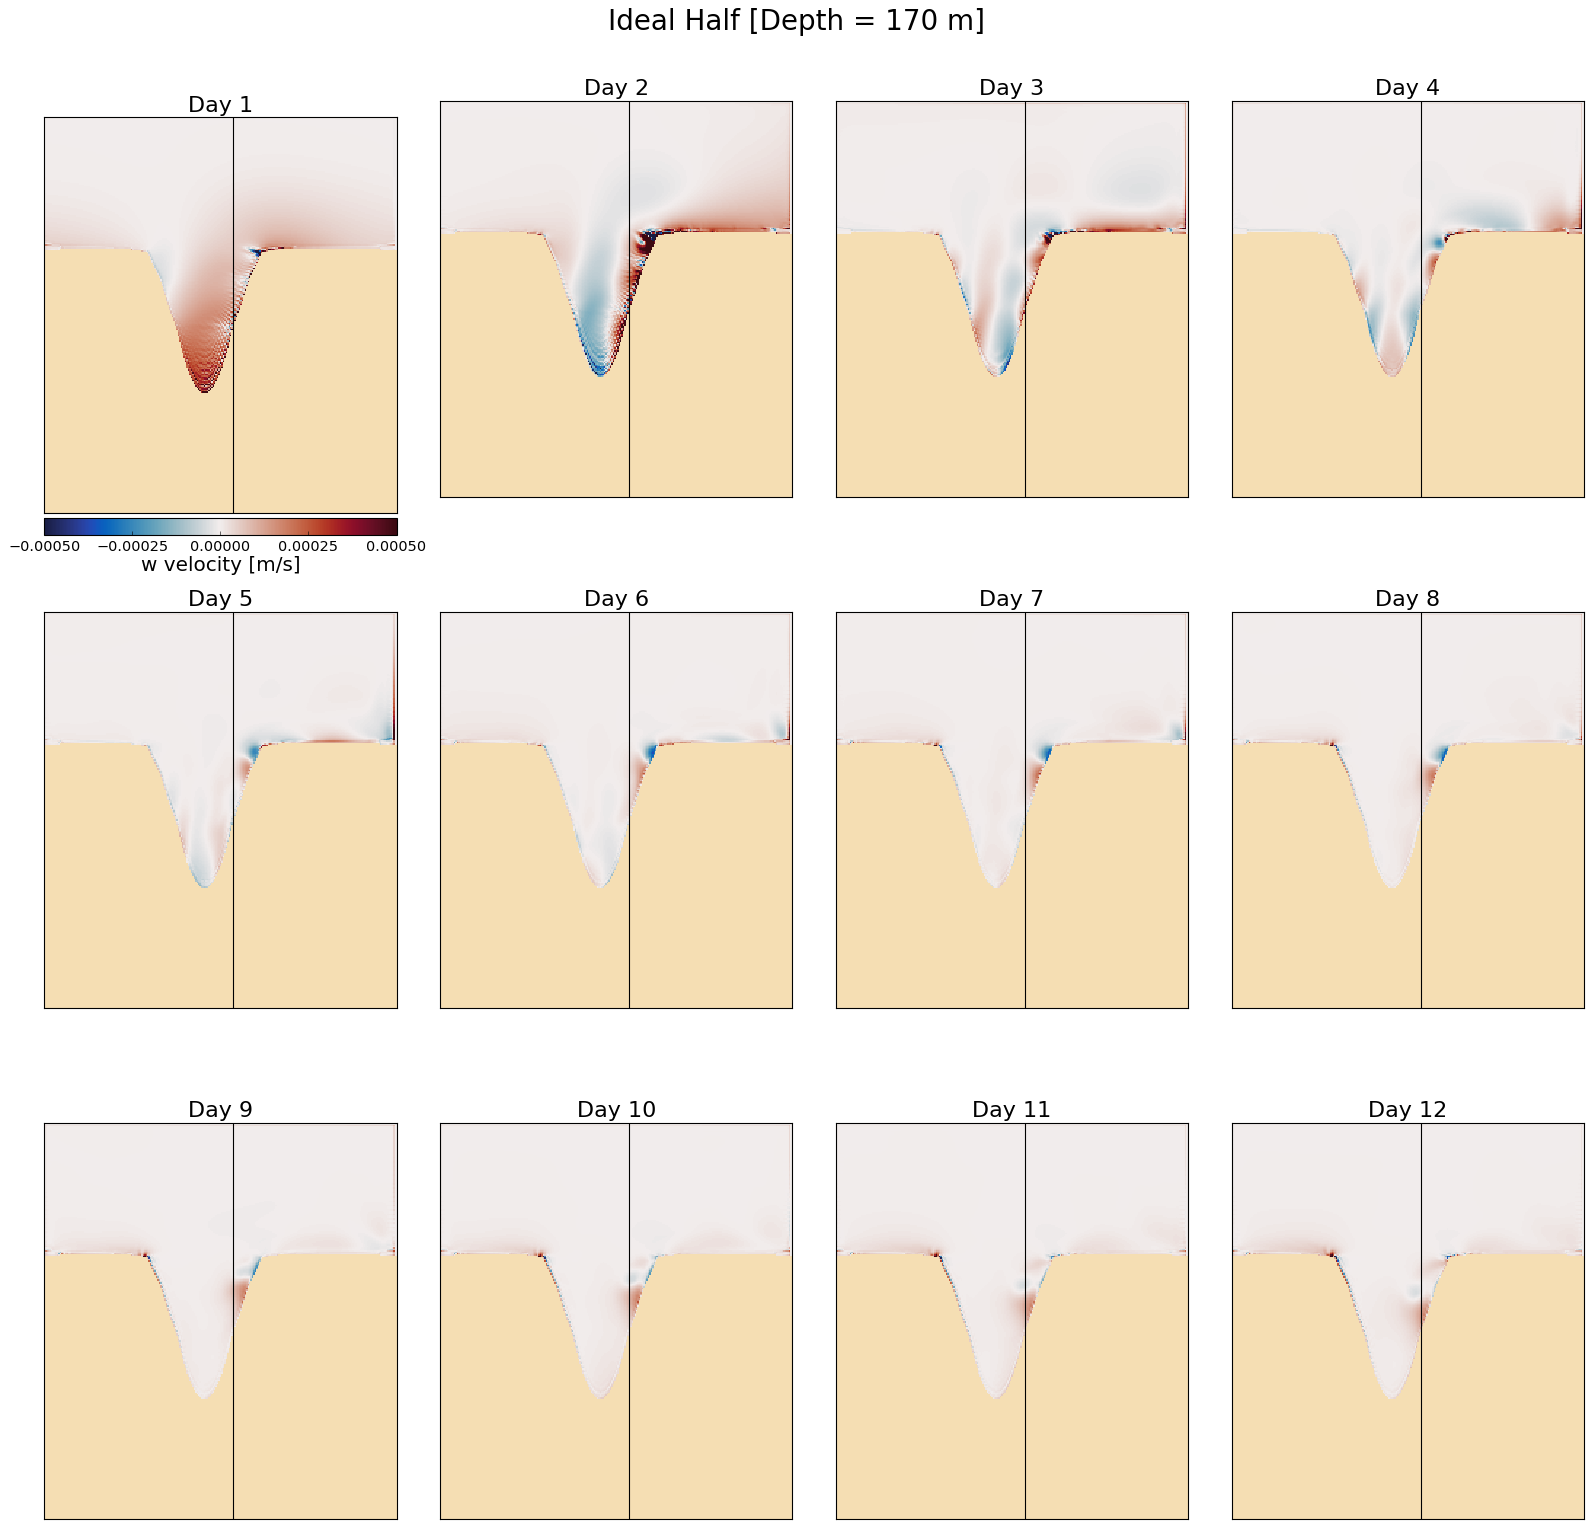

In [8]:
dep_ind = 19

dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_half_flt/'
vovecrtz, tmask, sozotaux, deptht = get_vars(dirname, dep_ind)
vovecrtz_daily, tmask_new = get_daily_w(vovecrtz, tmask)
fig = pcolor_story_panels(vovecrtz_daily, cmap, norm, -0.0005, 0.0005, 'Ideal Half', 'w velocity [m/s]')
vovecrtz_daily.max()

# Ideal_base

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


0.0044701310495535536

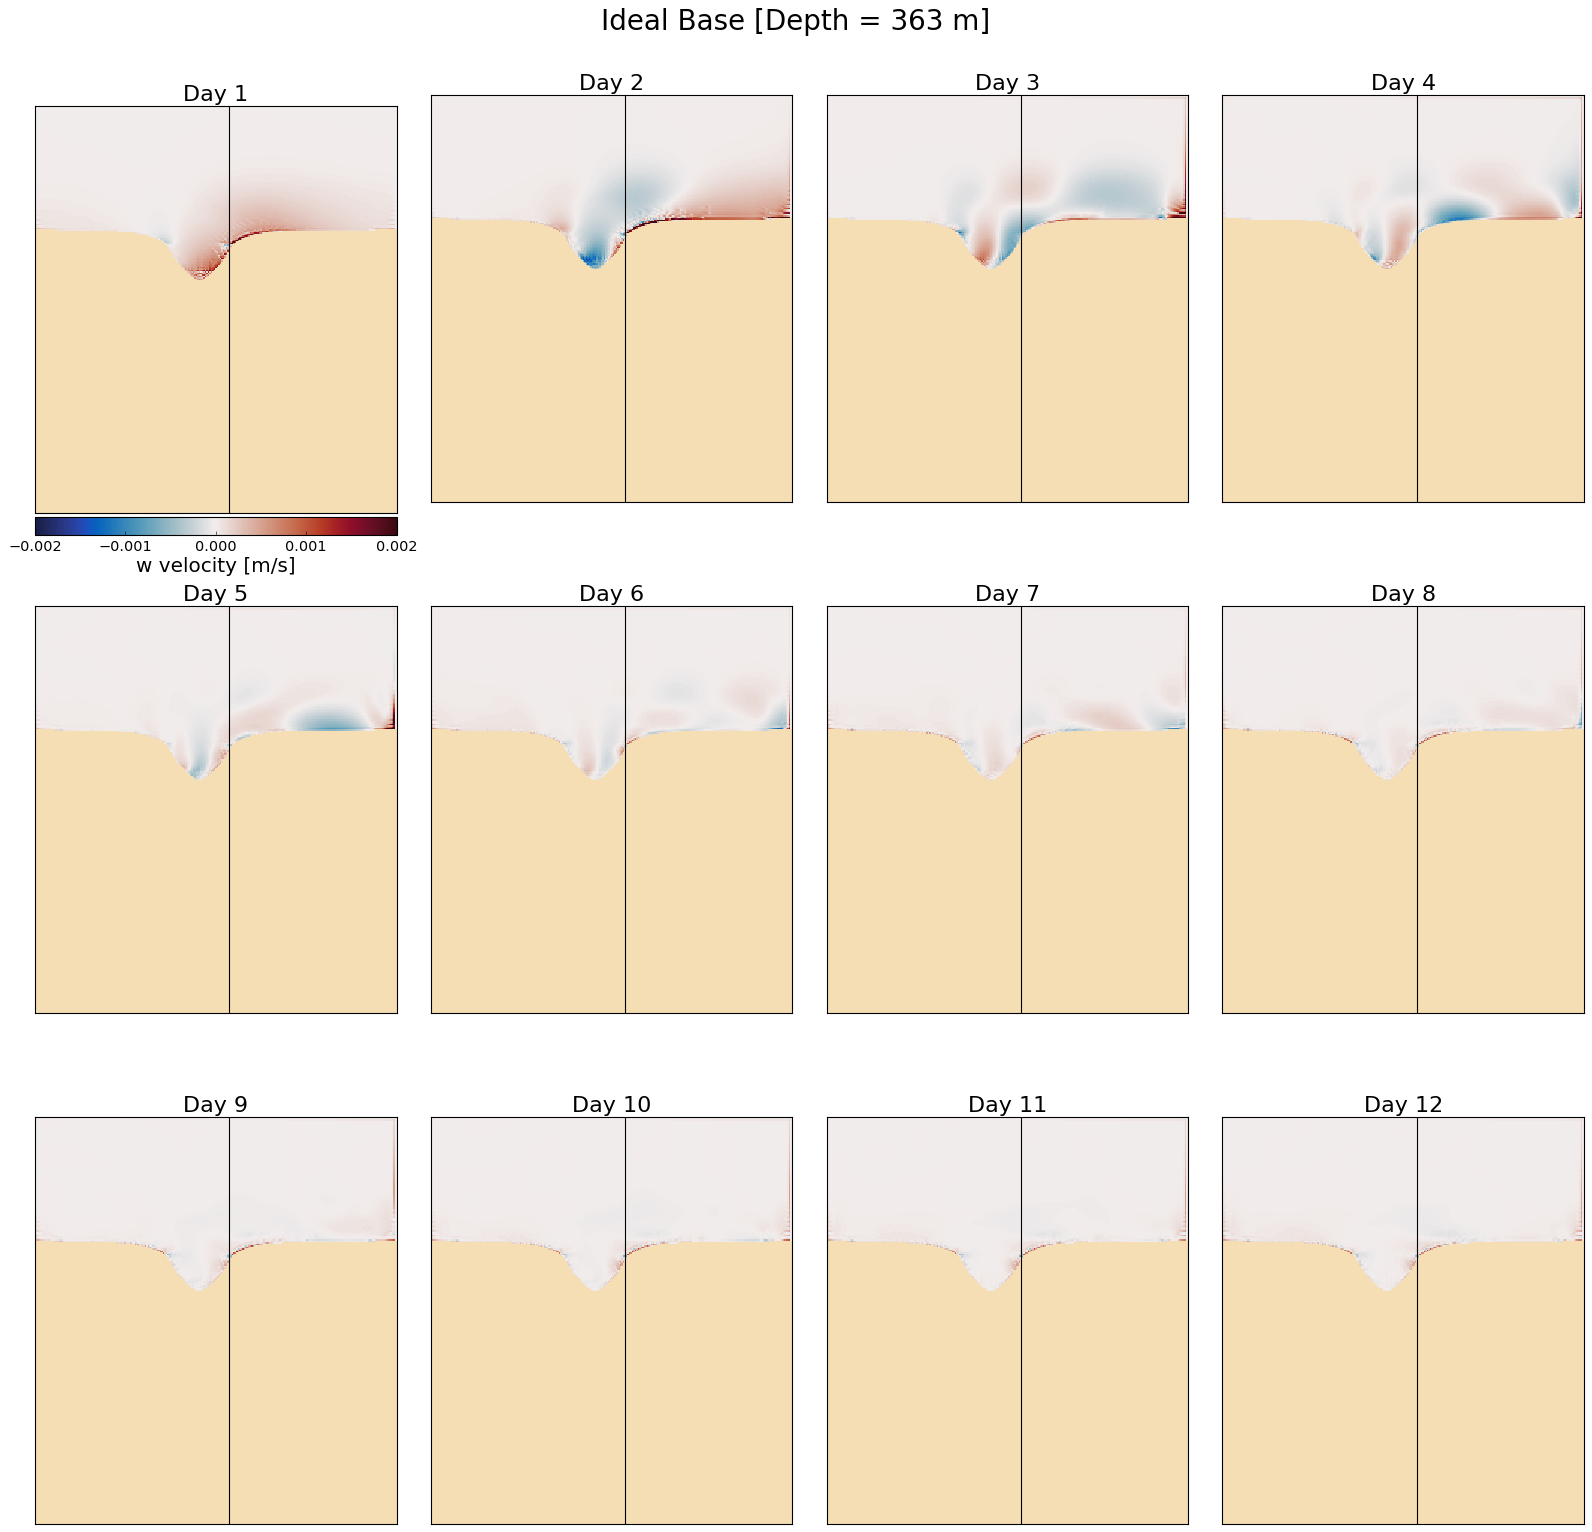

In [9]:
dep_ind = 41

dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_flt/'
vovecrtz, tmask, sozotaux, deptht = get_vars(dirname, dep_ind)
vovecrtz_daily, tmask_new = get_daily_w(vovecrtz, tmask)
fig = pcolor_story_panels(vovecrtz_daily, cmap, norm, -0.002, 0.002,'Ideal Base', 'w velocity [m/s]')
vovecrtz_daily.max()

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


0.0011289855465292931

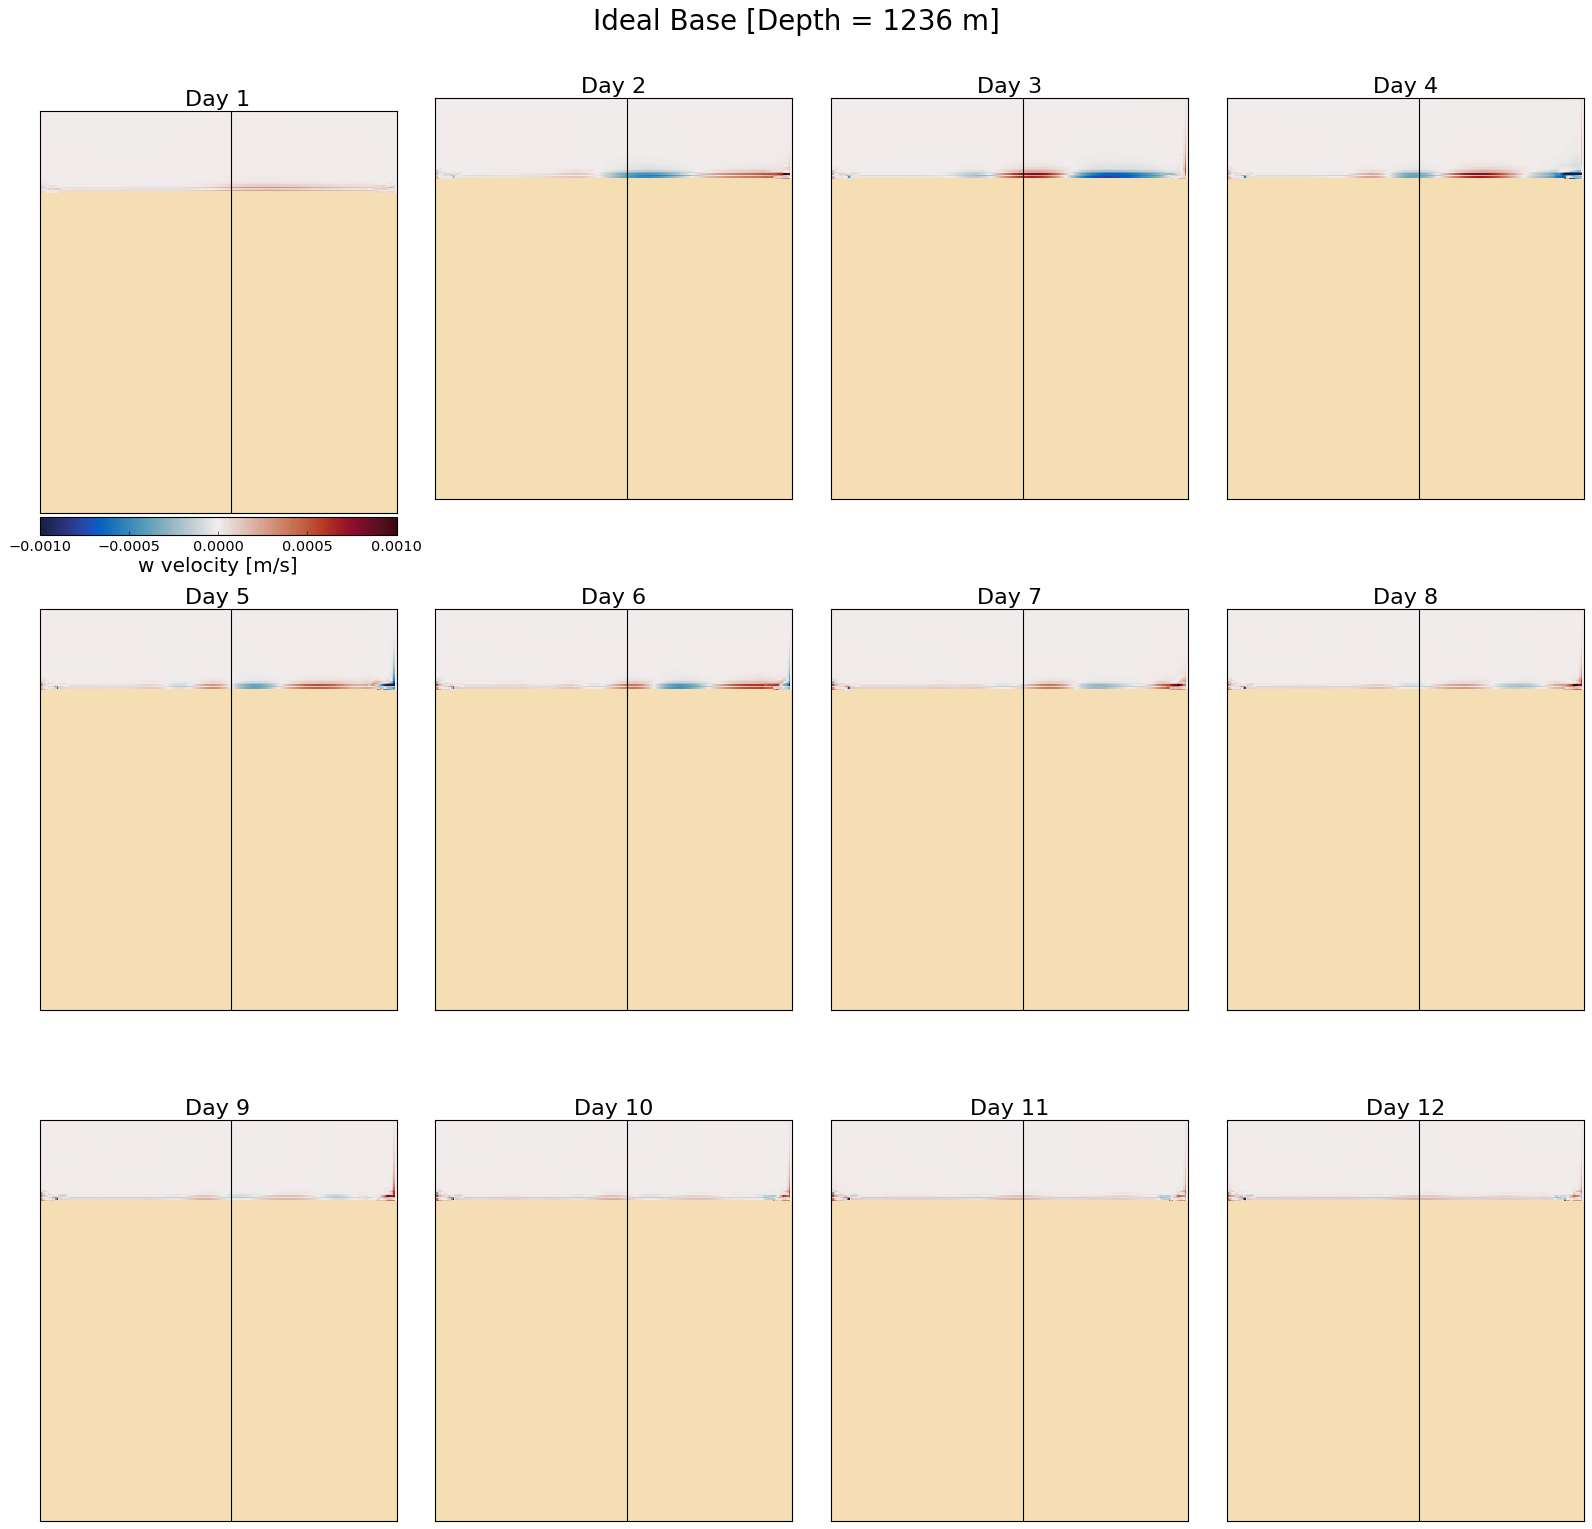

In [10]:
dep_ind = 77

dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_flt/'
vovecrtz, tmask, sozotaux, deptht = get_vars(dirname, dep_ind)
vovecrtz_daily, tmask_new = get_daily_w(vovecrtz, tmask)
fig = pcolor_story_panels(vovecrtz_daily, cmap, norm, -0.001, 0.001,'Ideal Base', 'w velocity [m/s]')
vovecrtz_daily.max()

# Ideal_double

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


0.019367169588804245

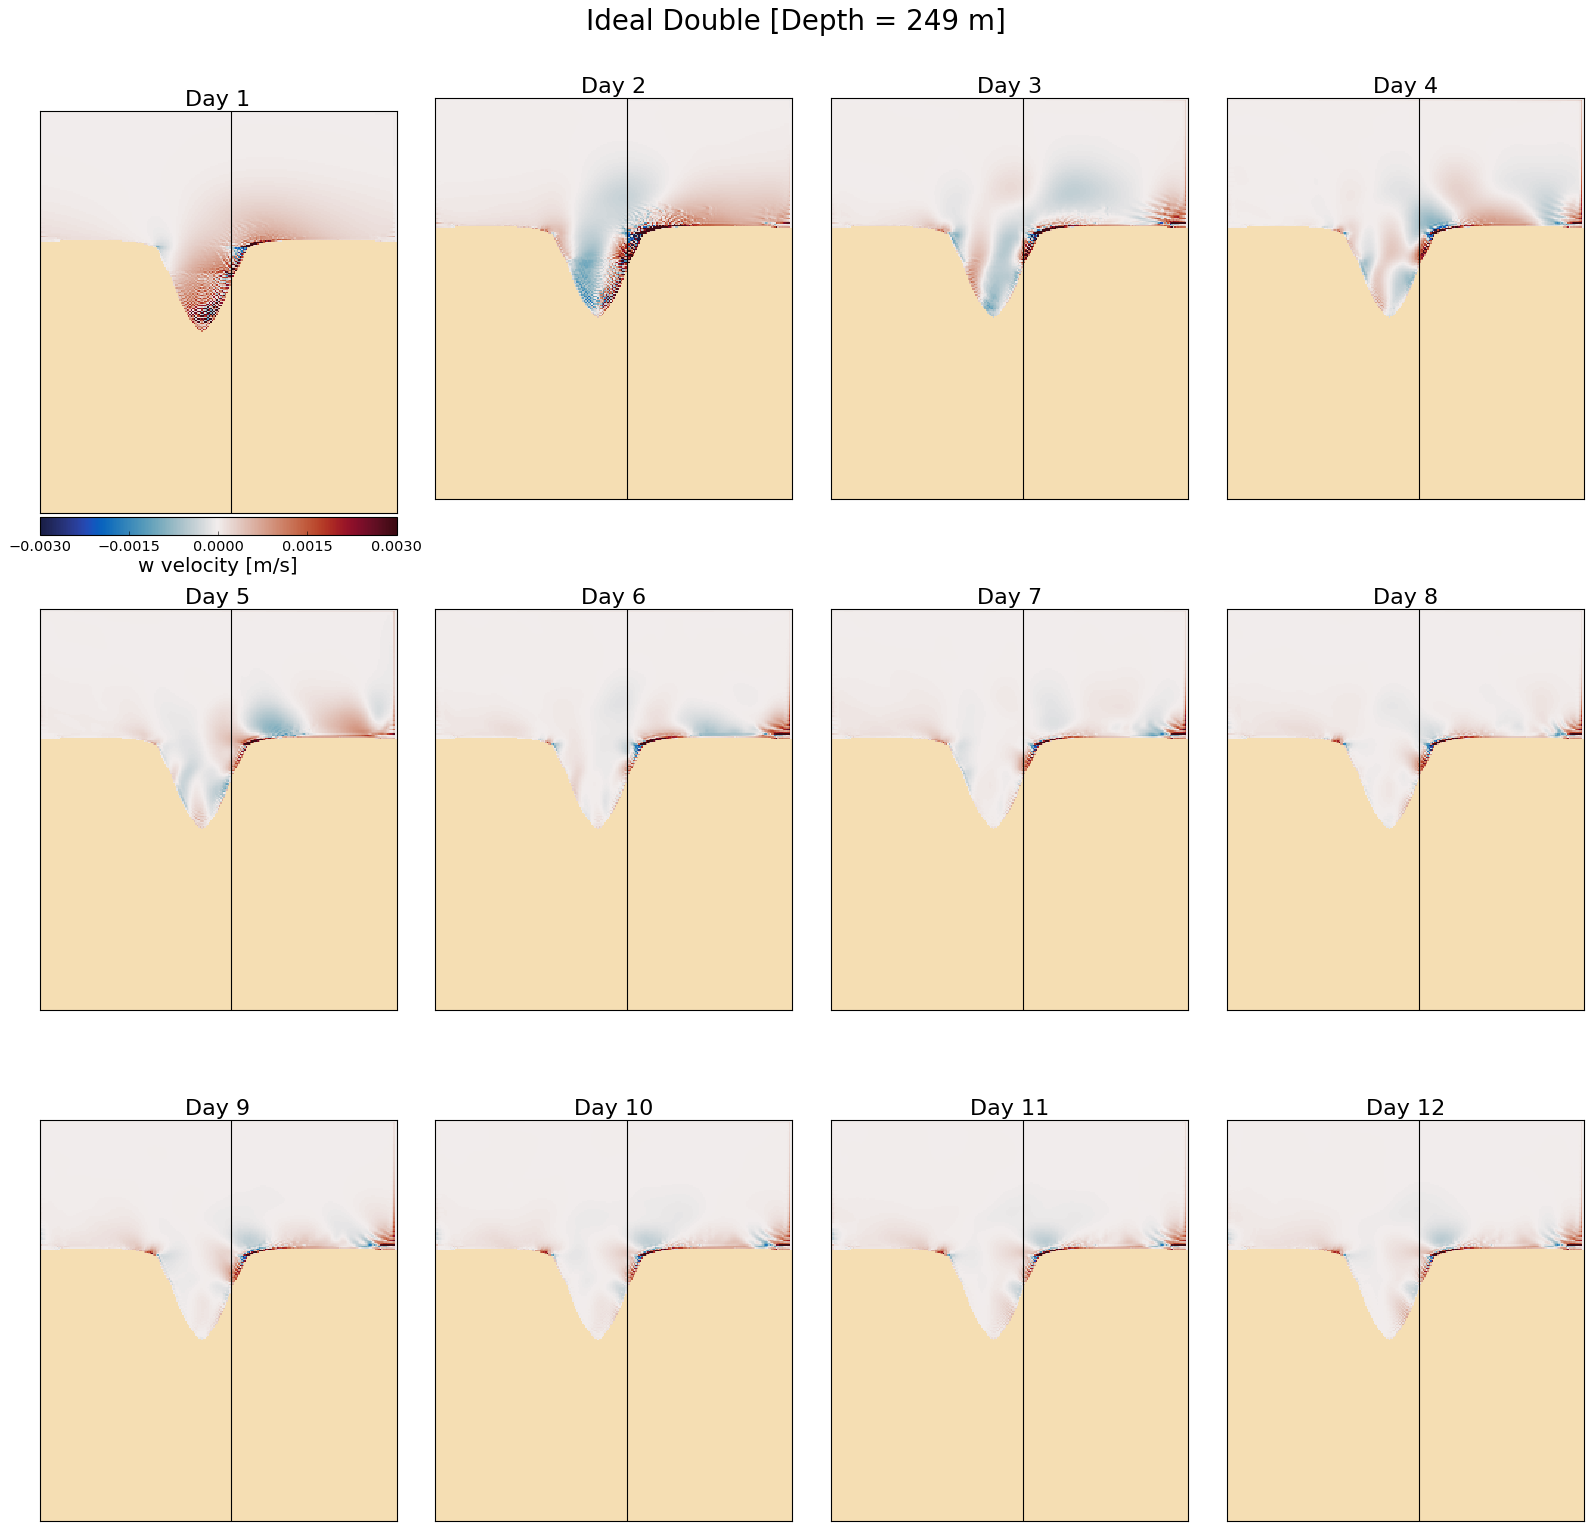

In [11]:
dep_ind = 28

dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_double_flt/'
vovecrtz, tmask, sozotaux, deptht = get_vars(dirname, dep_ind)
vovecrtz_daily, tmask_new = get_daily_w(vovecrtz, tmask)
fig = pcolor_story_panels(vovecrtz_daily, cmap, norm, -0.003, 0.003, 'Ideal Double', 'w velocity [m/s]')
vovecrtz_daily.max()

<class 'numpy.ndarray'> (13, 272, 242) (13, 272, 242) (13, 272, 242) <class 'numpy.ma.core.MaskedArray'>


masked

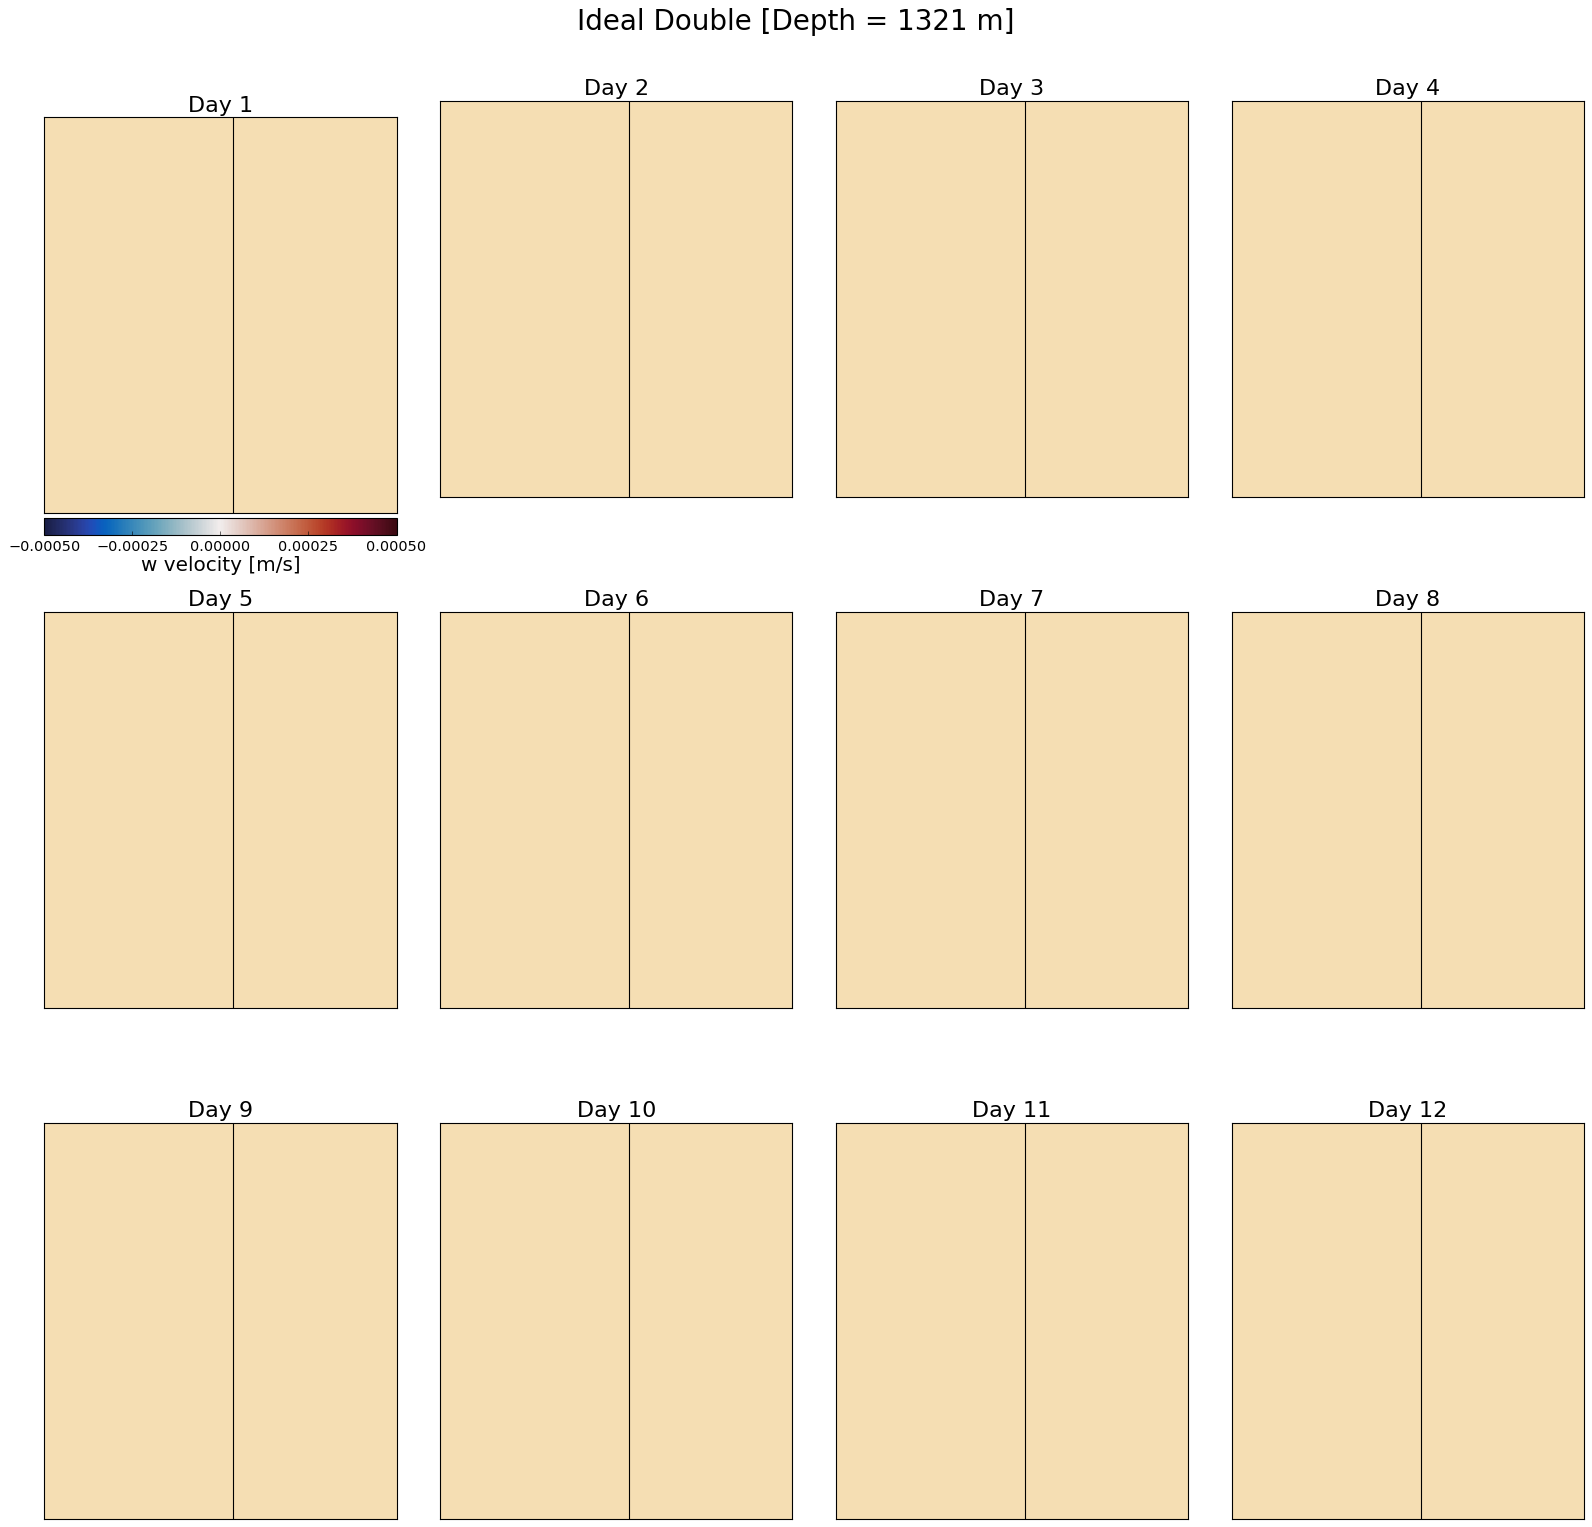

In [12]:
dep_ind = 79

dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_double_flt/'
vovecrtz, tmask, sozotaux, deptht = get_vars(dirname, dep_ind)
vovecrtz_daily, tmask_new = get_daily_w(vovecrtz, tmask)
fig = pcolor_story_panels(vovecrtz_daily, cmap, norm, -0.0005, 0.0005, 'Ideal Double', 'w velocity [m/s]')
vovecrtz_daily.max()